In [38]:
import numpy as np
import pandas as pd
#import geopandas as gp
import matplotlib.pyplot as plt
import folium

In [18]:
nl_covid = pd.read_csv('../data/Raw/corona/nl_corona.csv',sep='\t')
weather = pd.read_csv('../data/Raw/weather/weather.csv',sep='\t')
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df

#missing data?
print(nl_weather_df.isna().any().any())
nl_weather_df

False


,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
21,2020-02-13,NL-DR,91.711788,1.066942e+05,2.403207e+06,276.928340,0.010772,0.261780,4.431883
22,2020-02-13,NL-FL,89.725649,6.051013e+05,2.402642e+06,278.164065,0.012001,0.785507,6.057862
23,2020-02-13,NL-FR,91.979761,3.386435e+05,2.402547e+06,277.471187,0.009652,0.898502,5.811592
24,2020-02-13,NL-GE,88.672120,5.364181e+05,2.400907e+06,278.275055,0.012576,2.116279,4.602913
25,2020-02-13,NL-GR,91.948050,4.413943e+04,2.404533e+06,276.695832,0.009448,0.850829,4.974551
...,...,...,...,...,...,...,...,...,...
14878,2020-11-14,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843
14879,2020-11-14,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711
14880,2020-11-14,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365
14881,2020-11-14,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993


In [14]:
'''Finding min, median, max and mean for each numerical value, for each region in the Netherlands.'''
#print(nl_weather_df['iso3166-2'].unique())
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
reg_dict = {}
for i in nl_weather_df['iso3166-2'].unique():
    reg_dict[i] = {}
    for j in num_columns:
        reg_dict[i][j] = {'min': min(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'median':np.median(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'max':max(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'mean':np.mean(nl_weather_df[nl_weather_df['iso3166-2'] == i][j])}
#reg_dict['NL-GE']['RelativeHumiditySurface']

In [19]:
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
date_dict = {}
for i in nl_weather_df['date'].unique():
    date_dict[i] = {}
    for j in num_columns:
        date_dict[i][j] = np.mean(nl_weather_df[nl_weather_df['date'] == i][j])
#date_dict

<BarContainer object of 12 artists>

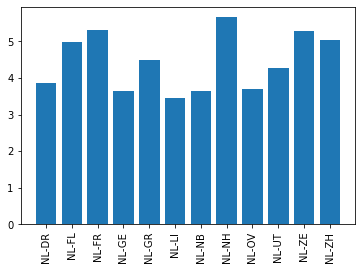

In [37]:
#Plotting means of windspeeds for different regions
means = [reg_dict[i]['WindSpeed']['mean'] for i in reg_dict.keys()]

plt.xticks(rotation=90)
plt.bar(reg_dict.keys(),means)

In [51]:
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.GeoJson('../Data/Raw/shapefiles/nl.geojson', name = "geojson").add_to(nl_map)
folium.LayerControl().add_to(nl_map)

nl_map